In [1]:
!pip install minio pandas pyarrow

In [2]:
from minio import Minio
import pandas as pd
from io import BytesIO

# Cliente MinIO (a partir do container do Jupyter, o host é "minio")
client = Minio(
    "minio:9000",
    access_key="minioadmin",
    secret_key="minioadmin",
    secure=False,
)

BUCKET = "inmet-raw"
PREFIX = "wind/raw/"


In [3]:
objects = list(client.list_objects(BUCKET, prefix=PREFIX, recursive=True))
for obj in objects:
    print(obj.object_name, obj.size)


wind/raw/vento_pe_20251128_003552.parquet 33987


In [4]:
# Pega o último arquivo (ou escolha manualmente um pelo nome)
latest_obj = sorted(objects, key=lambda o: o.object_name)[-1]
print("Lendo objeto:", latest_obj.object_name)

response = client.get_object(BUCKET, latest_obj.object_name)
data = response.read()
response.close()
response.release_conn()

df = pd.read_parquet(BytesIO(data))
df.head()


Lendo objeto: wind/raw/vento_pe_20251128_003552.parquet


,data,hora_utc,vento_direcao_(gr),vento_rajada_max_(m/s),vento_velocidade_(m/s)
0,2024/01/01,0000 UTC,41.0,"7,2","1,8"
1,2024/01/01,0100 UTC,44.0,"5,4","1,6"
2,2024/01/01,0200 UTC,15.0,"5,7","3,5"
3,2024/01/01,0300 UTC,9.0,"6,4",2
4,2024/01/01,0400 UTC,18.0,"3,5","1,6"


In [5]:
df.dtypes

data                       object
hora_utc                   object
vento_direcao_(gr)        float64
vento_rajada_max_(m/s)     object
vento_velocidade_(m/s)     object
dtype: object

In [6]:
def to_float_comma(x):
    if isinstance(x, str):
        x = x.replace(",", ".")
    try:
        return float(x)
    except:
        return None

df["vento_direcao_(gr)"] = df["vento_direcao_(gr)"].apply(to_float_comma)
df["vento_rajada_max_(m/s)"] = df["vento_rajada_max_(m/s)"].apply(to_float_comma)
df["vento_velocidade_(m/s)"] = df["vento_velocidade_(m/s)"].apply(to_float_comma)

df.head()


,data,hora_utc,vento_direcao_(gr),vento_rajada_max_(m/s),vento_velocidade_(m/s)
0,2024/01/01,0000 UTC,41.0,7.2,1.8
1,2024/01/01,0100 UTC,44.0,5.4,1.6
2,2024/01/01,0200 UTC,15.0,5.7,3.5
3,2024/01/01,0300 UTC,9.0,6.4,2.0
4,2024/01/01,0400 UTC,18.0,3.5,1.6


In [7]:
# "2024/01/01" + "0100 UTC" -> datetime
def parse_datetime(row):
    data = row["data"]
    hora = row["hora_utc"].split()[0]  # "0100" de "0100 UTC"
    # monta "2024/01/01 01:00"
    h = hora[:2]
    m = hora[2:]
    return pd.to_datetime(f"{data} {h}:{m}", format="%Y/%m/%d %H:%M")

df["datetime_utc"] = df.apply(parse_datetime, axis=1)
df = df.sort_values("datetime_utc").reset_index(drop=True)

df[["data", "hora_utc", "datetime_utc"]].head()


,data,hora_utc,datetime_utc
0,2024/01/01,0000 UTC,2024-01-01 00:00:00
1,2024/01/01,0100 UTC,2024-01-01 01:00:00
2,2024/01/01,0200 UTC,2024-01-01 02:00:00
3,2024/01/01,0300 UTC,2024-01-01 03:00:00
4,2024/01/01,0400 UTC,2024-01-01 04:00:00


In [8]:
df[["vento_direcao_(gr)", "vento_rajada_max_(m/s)", "vento_velocidade_(m/s)"]].describe()


,vento_direcao_(gr),vento_rajada_max_(m/s),vento_velocidade_(m/s)
count,8224.000000,8212.000000,8224.000000
mean,96.432028,7.061471,2.281627
std,45.424577,1.882300,0.896232
min,1.000000,1.300000,0.200000
25%,69.000000,5.800000,1.700000
50%,87.000000,7.000000,2.100000
75%,124.000000,8.200000,2.700000
max,360.000000,16.800000,7.100000


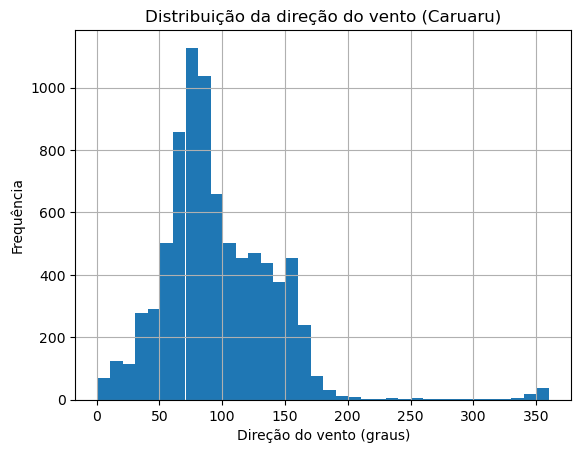

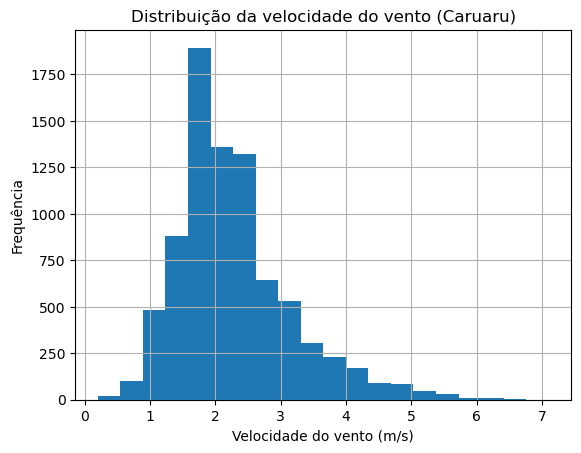

In [9]:
import matplotlib.pyplot as plt

# Histograma de direção do vento
plt.figure()
df["vento_direcao_(gr)"].hist(bins=36)  # ~10 graus cada bin
plt.xlabel("Direção do vento (graus)")
plt.ylabel("Frequência")
plt.title("Distribuição da direção do vento (Caruaru)")
plt.show()

# Histograma de velocidade
plt.figure()
df["vento_velocidade_(m/s)"].hist(bins=20)
plt.xlabel("Velocidade do vento (m/s)")
plt.ylabel("Frequência")
plt.title("Distribuição da velocidade do vento (Caruaru)")
plt.show()


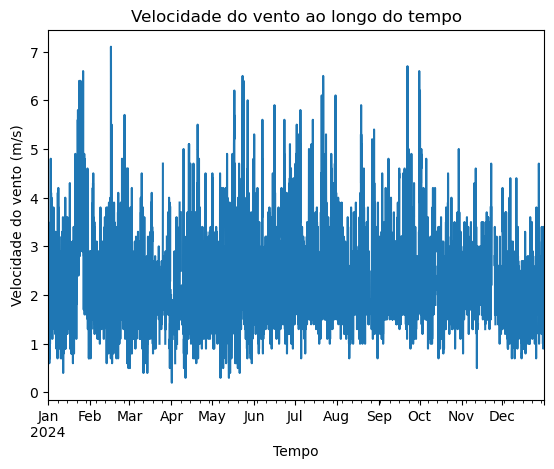

In [10]:
plt.figure()
df.set_index("datetime_utc")["vento_velocidade_(m/s)"].plot()
plt.xlabel("Tempo")
plt.ylabel("Velocidade do vento (m/s)")
plt.title("Velocidade do vento ao longo do tempo")
plt.show()
